# Final Project

In [1]:
import os
import numpy as np
import cv2  
from matplotlib import pyplot as plt

from PIL import Image
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

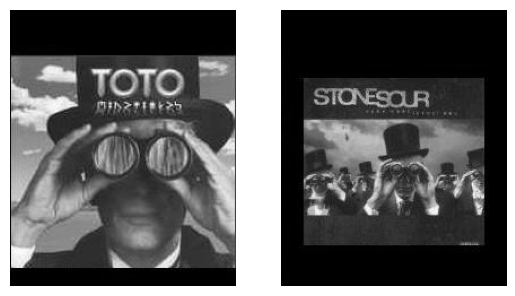

In [2]:
left_rootpath='./train/left/'
right_rootpath='./train/right/'
leftImage = cv2.imread(os.path.join(left_rootpath, "aaa.jpg"),cv2.IMREAD_GRAYSCALE)
rightImage = cv2.imread(os.path.join(right_rootpath, "osr.jpg"),cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.imshow(leftImage, cmap='gray') 
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(rightImage, cmap='gray') 
plt.axis('off')

plt.show()


C:\Users\Brandon\AppData\Local\Temp\ipykernel_1404\4085412333.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


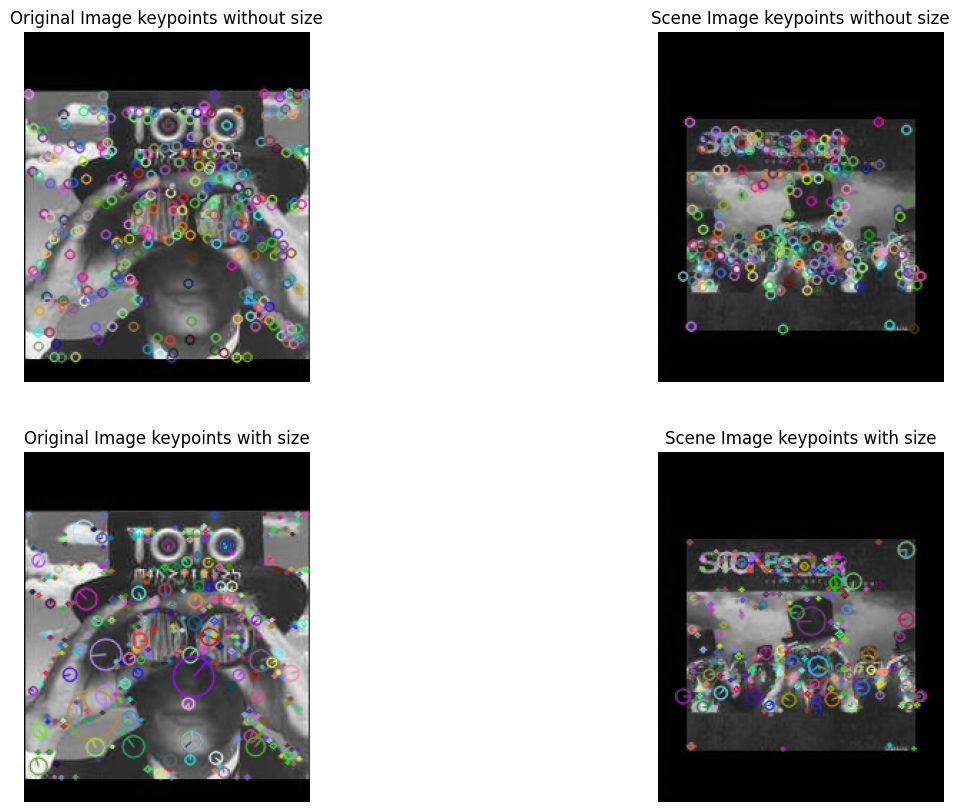

In [3]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(leftImage,None)
kp2, des2 = sift.detectAndCompute(rightImage,None)

kp1_without_size = cv2.drawKeypoints(leftImage,kp1,None
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )
kp2_without_size = cv2.drawKeypoints(rightImage,kp2,None
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )

kp1_with_size = cv2.drawKeypoints(leftImage,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_with_size = cv2.drawKeypoints(rightImage,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplots(figsize=(15, 10)) 

plt.subplot(2,2,1)
plt.imshow(kp1_without_size, cmap='gray')  
plt.title('Original Image keypoints without size')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(kp2_without_size, cmap='gray')  
plt.title('Scene Image keypoints without size')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(kp1_with_size, cmap='gray')  
plt.title('Original Image keypoints with size')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(kp2_with_size, cmap='gray')  
plt.title('Scene Image keypoints with size')
plt.axis('off')

plt.show() 


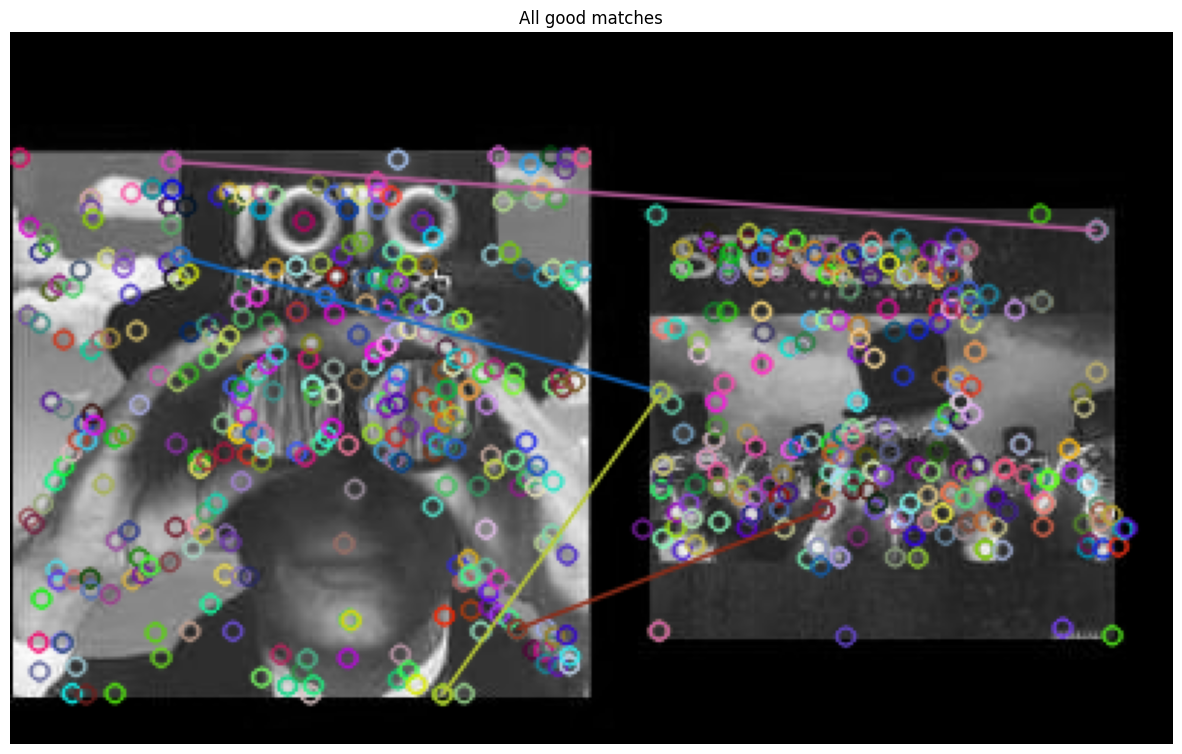


Number of good matches between two images:  4


In [5]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1,des2,k=2)

# Create a mask to draw all good matches
matchesMask = []

# Store all good matches as per Lowe's Ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        matchesMask.append([1,0]) # Match
    else:
        matchesMask.append([0,0]) # Mismatch
       
        
# Draw all good matches
draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                   #singlePointColor = (255,0,0), #If you want a specific colour
                    matchesMask = matchesMask,
                    flags = cv2.DrawMatchesFlags_DEFAULT)

good_matches = cv2.drawMatchesKnn(leftImage,kp1,rightImage,kp2,matches,None,**draw_params)


plt.figure(figsize=(15, 15))

plt.imshow(good_matches)
plt.title('All good matches')
plt.axis('off')

plt.show()

# Print total number of good matches between two images
print("\nNumber of good matches between two images: ", len(good))


Number of successful matches between two images:  5


C:\Users\Brandon\AppData\Local\Temp\ipykernel_86944\1283215781.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


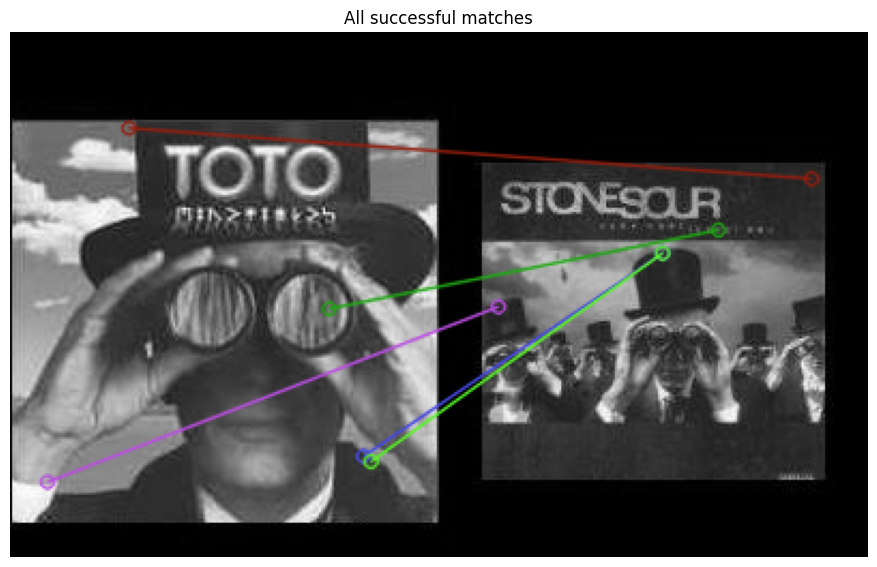

In [49]:
# Now we set a condition that at least N matches (defined by MIN_MATCH_NUM) are required to find the object. 
MIN_MATCH_NUM = 4

if len(good)>= MIN_MATCH_NUM:
    # If enough matches are found, we extract the positions of the matched keypoints in both images. 
    # They are passed to find the perspective transformation. 
    
    # Estimate homography between two images
    ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, status = cv2.findHomography(ptsA, 
                                   ptsB, 
                                   cv2.RANSAC, 
                                   ransacReprojThreshold = 5, 
                                   maxIters = 10) # try to change maxIters and see the effect
    # Where H is the resulting single-strain matrix.
    # status returns a list of feature points that represent successful matches.
    # ptsA, ptsB are keypoints.
    # The three parameters cv2.RANSAC, ransacReprojThreshold, maxIters are related to RANSAC.
    # ransacReprojThreshold: Maximum reprojection error in the RANSAC algorithm to consider a point as an inlier. 
    # maxIters: The maximum number of RANSAC-based robust method iterations.
    
    success = status.ravel().tolist()
    
    # Draw detected template in scene image
    imgOut = cv2.warpPerspective(rightImage, H, (leftImage.shape[1],leftImage.shape[0]),
                             flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    # Print total number of successful matches between two images
    print("\nNumber of successful matches between two images: ", success.count(1)) # Returns the number of 1 in the success list

else:
    # Otherwise, print that “Not enough matches are found”.
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_NUM) )
    success = None


# Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
draw_params = dict(#matchColor = (0,255,0), # draw in a specific colour
                   #singlePointColor = (255,0,0), # draw in a specific colour
                   matchesMask = success, # draw only inliers
                   flags = 2)

success_matches = cv2.drawMatches(leftImage,kp1,rightImage,kp2,good,None,**draw_params)


# Plotting results
plt.subplots(figsize=(15, 15)) 

if success == None:
    plt.imshow(success_matches)
    plt.title('All matching keypoints')
    plt.axis('off')
    
else:
    plt.subplot(2,1,1)
    plt.imshow(success_matches)
    plt.title('All successful matches')
    plt.axis('off')
    


plt.show()

In [7]:
vgg16 = VGG16(weights='imagenet', include_top=False, 
              pooling='max', input_shape=(224, 224, 3))

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
for model_layer in vgg16.layers:
  model_layer.trainable = False

In [9]:
leftImage='./train/left/aaa.jpg'
rightImage='./train/right/osr.jpg'


def load_image(image_path):
    """
        -----------------------------------------------------
        Process the image provided. 
        - Resize the image 
        -----------------------------------------------------
        return resized image
    """

    input_image = Image.open(image_path)
    resized_image = input_image.resize((224, 224))

    return resized_image

def get_image_embeddings(object_image : image):
    
    """
      -----------------------------------------------------
      convert image into 3d array and add additional dimension for model input
      -----------------------------------------------------
      return embeddings of the given image
    """

    image_array = np.expand_dims(image.img_to_array(object_image), axis = 0)
    image_embedding = vgg16.predict(image_array)

    return image_embedding


def get_similarity_score(first_image : str, second_image : str):
    """
        -----------------------------------------------------
        Takes image array and computes its embedding using VGG16 model.
        -----------------------------------------------------
        return embedding of the image
        
    """

    first_image = load_image(first_image)
    second_image = load_image(second_image)

    first_image_vector = get_image_embeddings(first_image)
    second_image_vector = get_image_embeddings(second_image)
    
    similarity_score = cosine_similarity(first_image_vector, second_image_vector).reshape(1,)

    return similarity_score



similarity = get_similarity_score(leftImage, rightImage)
print(similarity)

1/1 [==============================] - 0s 75ms/step
[0.5868552]


Generating the new train excel file, including a left image, with 4 random right images, and its ground truth

In [5]:
import pandas as pd
import random

df = pd.read_csv('train.csv')

all_right_images = df['right'].tolist()

new_data = []

for index, row in df.iterrows():
    left_image = row['left']
    true_match = row['right']
    
    random_images = [img for img in all_right_images if img != true_match]
    random_images = random.sample(random_images, 4)
    
    position = random.randint(0, 4)
    random_images.insert(position, true_match)
    
    new_entry = {'left': left_image, 
                 'right1': random_images[0], 
                 'right2': random_images[1], 
                 'right3': random_images[2], 
                 'right4': random_images[3], 
                 'right5': random_images[4], 
                 'groundtruth': true_match}
    
    new_data.append(pd.DataFrame([new_entry]))

new_df = pd.concat(new_data, ignore_index=True)

new_df.to_csv('newTrain.csv', index=False)

Calculating the similarity scores into an excel file (for visualization purposes)

In [6]:

new_df = pd.read_csv('newTrain.csv')

similarity_df = pd.DataFrame(columns=['left', 'right1', 'right2', 'right3', 'right4', 'right5','groundtruth'])

for index, row in new_df.iterrows():
    left_image = f"./train/left/{row['left']}.jpg"
    
    similarity_scores = {'left': row['left']}
    matching_right_idx = None
    
    for i in range(1, 6):
        right_image = f"./train/right/{row[f'right{i}']}.jpg"
        
        similarity = get_similarity_score(left_image, right_image)[0]
        
        similarity_scores[f'right{i}'] = similarity

        if row[f'right{i}'] == row['groundtruth']:
            matching_right_idx = i
    
    if matching_right_idx is not None:
        similarity_scores['groundtruth'] = matching_right_idx
    else:
        print(f"No match found for {row['left']}, omitting this entry.")
        continue
    
    temp_df = pd.DataFrame([similarity_scores], columns=similarity_scores.keys())
    similarity_df = pd.concat([similarity_df, temp_df], ignore_index=True)

similarity_df.to_csv('newTrainScores.csv', index=False)

1/1 [==============================] - 0s 252ms/step


In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import random
data = pd.read_csv("newTrainScores.csv")

for i in range(1, 6):
    col_name = f'right{i}'
    data[col_name] = (data[col_name] - data[col_name].min()) / (data[col_name].max() - data[col_name].min())

encoder = OneHotEncoder(sparse=False)
targets = encoder.fit_transform(data['groundtruth'].values.reshape(-1, 1))

X = data[['right1', 'right2', 'right3', 'right4', 'right5']].values
y = targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(5,)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=32
)

model.summary()
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/60


C:\Users\Brandon\anaconda3\envs\CV\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


15/15 [==============================] - 0s 7ms/step - loss: 1.6143 - accuracy: 0.1962 - val_loss: 1.5992 - val_accuracy: 0.3167
Epoch 2/60
15/15 [==============================] - 0s 2ms/step - loss: 1.5997 - accuracy: 0.2484 - val_loss: 1.5956 - val_accuracy: 0.3000
Epoch 3/60
15/15 [==============================] - 0s 2ms/step - loss: 1.5914 - accuracy: 0.2505 - val_loss: 1.5866 - val_accuracy: 0.3500
Epoch 4/60
15/15 [==============================] - 0s 2ms/step - loss: 1.5913 - accuracy: 0.2380 - val_loss: 1.5809 - val_accuracy: 0.3250
Epoch 5/60
15/15 [==============================] - 0s 2ms/step - loss: 1.5876 - accuracy: 0.2547 - val_loss: 1.5783 - val_accuracy: 0.2583
Epoch 6/60
15/15 [==============================] - 0s 2ms/step - loss: 1.5581 - accuracy: 0.2735 - val_loss: 1.5711 - val_accuracy: 0.2833
Epoch 7/60
15/15 [==============================] - 0s 2ms/step - loss: 1.5460 - accuracy: 0.3403 - val_loss: 1.5596 - val_accuracy: 0.3500
Epoch 8/60
15/15 [=============

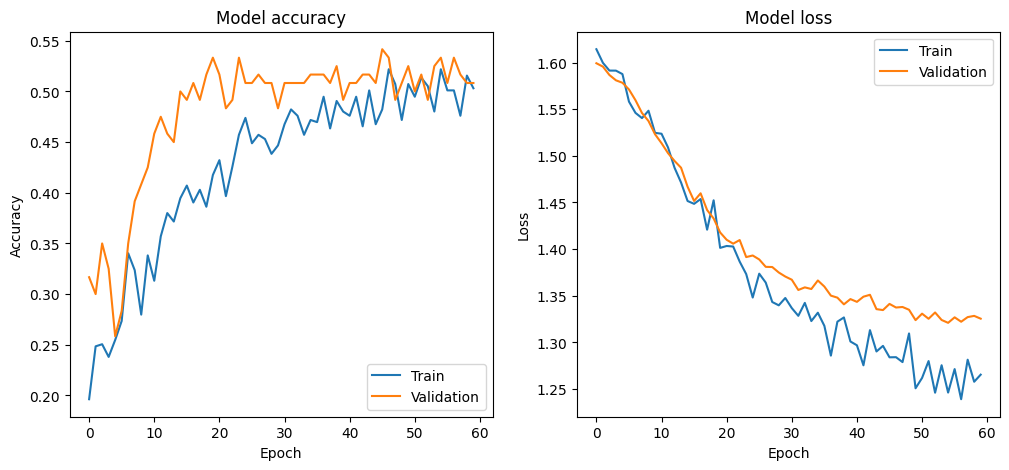

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [2]:
resnet50 = ResNet50(weights='imagenet', include_top=False, 
                    pooling='max', input_shape=(224, 224, 3))

resnet50.summary()

for model_layer in resnet50.layers:
    model_layer.trainable = False

# for layer in resnet50.layers[-5:]:
#     layer.trainable = True

leftImage='./train/left/aaa.jpg'
rightImage='./train/right/osr.jpg'

def load_image(image_path):
    """
    Load and preprocess the image.
    """
    input_image = Image.open(image_path)
    resized_image = input_image.resize((224, 224))

    return resized_image

def get_image_embeddings(object_image: Image.Image):
    """
    Get the embeddings of the image using ResNet50.
    """
    # Ensure the image is in array form and preprocess it
    image_array = np.expand_dims(image.img_to_array(object_image), axis=0)
    image_array = preprocess_input(image_array)  # Ensure the pre-processing is compatible with ResNet50
    
    # Get the embeddings of the image
    image_embedding = resnet50.predict(image_array)

    return image_embedding

def get_similarity_score(first_image_path: str, second_image_path: str):
    """
    Get the cosine similarity between the embeddings of two images.
    """
    first_image = load_image(first_image_path)
    second_image = load_image(second_image_path)

    first_image_vector = get_image_embeddings(first_image)
    second_image_vector = get_image_embeddings(second_image)

    similarity_score = cosine_similarity(first_image_vector, second_image_vector).reshape(1,)

    return similarity_score


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [1]:
leftImage='./train/left/aaa.jpg'
rightImage='./train/right/osr.jpg'

similarity = get_similarity_score(leftImage, rightImage)
print(similarity)

NameError: name 'get_similarity_score' is not defined

In [3]:

import pandas as pd
import random
df = pd.read_csv('test_candidates.csv')

left_image_dir = './test/left/'
right_image_dir = './test/right/'

for idx, row in df.iloc[1900:2000].iterrows():
    left_image_name = row['left']
    left_image_path = left_image_dir + left_image_name + '.jpg'  
    
    for col in df.columns[1:]: 
        right_image_name = row[col]
        right_image_path = right_image_dir + right_image_name + '.jpg'
        
        similarity = get_similarity_score(left_image_path, right_image_path)
        df.at[idx, col] = similarity[0]  

df.to_csv('test_similarity_scores4.csv', index=False)

1/1 [==============================] - 0s 147ms/step
